# Lab 5 - Embedding Adaptors

In [ ]:
# !pip install chromadb
# !pip install langchain
# !pip install umap-learn
# !pip install pypdf
# !pip install sentence_transformers
# !pip install openai

In [2]:
from helper_utils import load_chroma, word_wrap, project_embeddings
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction
import numpy as np
# import umap
import umap.umap_ as umap
from tqdm import tqdm

import torch

In [ ]:
embedding_function = SentenceTransformerEmbeddingFunction()

chroma_collection = load_chroma(filename='microsoft_annual_report_2022.pdf', collection_name='microsoft_annual_report_2022', embedding_function=embedding_function)

In [4]:
chroma_collection.count()

349

In [5]:
embeddings = chroma_collection.get(include=['embeddings'])['embeddings']
umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(embeddings)
projected_dataset_embeddings = project_embeddings(embeddings, umap_transform)

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
100%|██████████| 349/349 [05:08<00:00,  1.13it/s]


In [6]:
import os
import openai
from openai import OpenAI

In [ ]:
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file
openai.api_key = os.environ['OPENAI_API_KEY']

openai_client = OpenAI()

## Creating a dataset

In [8]:
def generate_queries(model="gpt-3.5-turbo"):
    messages = [
        {
            "role": "system",
            "content": "You are a helpful expert financial research assistant. You help users analyze financial statements to better understand companies. "
            "Suggest 10 to 15 short questions that are important to ask when analyzing an annual report. "
            "Do not output any compound questions (questions with multiple sentences or conjunctions)."
            "Output each question on a separate line divided by a newline."
        },
    ]

    response = openai_client.chat.completions.create(
        model=model,
        messages=messages,
    )
    content = response.choices[0].message.content
    content = content.split("\n")
    return content

In [9]:
generated_queries = generate_queries()
for query in generated_queries:
    print(query)

1. What are the company's total revenues for the year?
2. What is the net income of the company?
3. How much cash does the company have on hand?
4. What is the company's total debt?
5. What is the company's operating cash flow?
6. How much has the company invested in capital expenditures?
7. What is the company's current ratio?
8. How much does the company spend on research and development?
9. What is the company's earnings per share?
10. How much does the company pay out in dividends?
11. What is the company's return on equity?
12. What are the company's total assets?
13. What is the breakdown of the company's revenue by segment or product?
14. What is the company's gross profit margin?
15. How much is the CEO's total compensation?


In [10]:
results = chroma_collection.query(query_texts=generated_queries, n_results=10, include=['documents', 'embeddings'])
retrieved_documents = results['documents']

In [11]:
def evaluate_results(query, statement, model="gpt-3.5-turbo"):
    messages = [
    {
        "role": "system",
        "content": "You are a helpful expert financial research assistant. You help users analyze financial statements to better understand companies. "
        "For the given query, evaluate whether the following satement is relevant."
        "Output only 'yes' or 'no'."
    },
    {
        "role": "user",
        "content": f"Query: {query}, Statement: {statement}"
    }
    ]

    response = openai_client.chat.completions.create(
        model=model,
        messages=messages,
        max_tokens=1
    )
    content = response.choices[0].message.content
    if content == "yes":
        return 1
    return -1

In [12]:
retrieved_embeddings = results['embeddings']
query_embeddings = embedding_function(generated_queries)

In [17]:
adapter_query_embeddings = []
adapter_doc_embeddings = []
adapter_labels = []

In [18]:
for q, query in enumerate(tqdm(generated_queries)):
    for d, document in enumerate(retrieved_documents[q]):
        adapter_query_embeddings.append(query_embeddings[q])
        adapter_doc_embeddings.append(retrieved_embeddings[q][d])
        adapter_labels.append(evaluate_results(query, document))

100%|██████████| 15/15 [01:14<00:00,  4.96s/it]


In [19]:
len(adapter_labels)

150

In [20]:
adapter_query_embeddings = torch.Tensor(np.array(adapter_query_embeddings))
adapter_doc_embeddings = torch.Tensor(np.array(adapter_doc_embeddings))
adapter_labels = torch.Tensor(np.expand_dims(np.array(adapter_labels),1))

In [23]:
print(adapter_query_embeddings.shape)
print(adapter_doc_embeddings.shape)
print(adapter_labels.shape)

torch.Size([150, 384])
torch.Size([150, 384])
torch.Size([150, 1])


In [21]:
dataset = torch.utils.data.TensorDataset(adapter_query_embeddings, adapter_doc_embeddings, adapter_labels)

## Setting up the model

In [24]:
def model(query_embedding, document_embedding, adaptor_matrix):
    updated_query_embedding = torch.matmul(adaptor_matrix, query_embedding)
    return torch.cosine_similarity(updated_query_embedding, document_embedding, dim=0)


In [25]:
def mse_loss(query_embedding, document_embedding, adaptor_matrix, label):
    return torch.nn.MSELoss()(model(query_embedding, document_embedding, adaptor_matrix), label)

In [26]:
# Initialize the adaptor matrix
mat_size = len(adapter_query_embeddings[0])
adapter_matrix = torch.randn(mat_size, mat_size, requires_grad=True)

In [27]:
min_loss = float('inf')
best_matrix = None

for epoch in tqdm(range(100)):
    for query_embedding, document_embedding, label in dataset:
        loss = mse_loss(query_embedding, document_embedding, adapter_matrix, label)

        if loss < min_loss:
            min_loss = loss
            best_matrix = adapter_matrix.clone().detach().numpy()

        loss.backward()
        with torch.no_grad():
            adapter_matrix -= 0.01 * adapter_matrix.grad
            adapter_matrix.grad.zero_()


  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 100/100 [00:12<00:00,  8.26it/s]


In [28]:
print(f"Best loss: {min_loss.detach().numpy()}")

Best loss: 0.44478651881217957


In [29]:
test_vector = torch.ones((mat_size,1))
scaled_vector = np.matmul(best_matrix, test_vector).numpy()

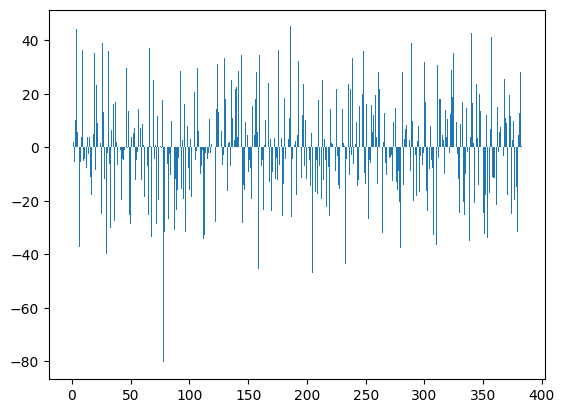

In [30]:
import matplotlib.pyplot as plt
plt.bar(range(len(scaled_vector)), scaled_vector.flatten())
plt.show()


In [31]:
query_embeddings = embedding_function(generated_queries)
adapted_query_embeddings = np.matmul(best_matrix, np.array(query_embeddings).T).T

projected_query_embeddings = project_embeddings(query_embeddings, umap_transform)
projected_adapted_query_embeddings = project_embeddings(adapted_query_embeddings, umap_transform)

100%|██████████| 15/15 [00:13<00:00,  1.13it/s]


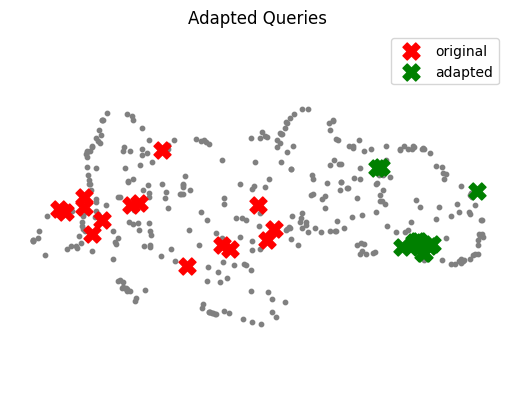

In [32]:
# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_query_embeddings[:, 0], projected_query_embeddings[:, 1], s=150, marker='X', color='r', label="original")
plt.scatter(projected_adapted_query_embeddings[:, 0], projected_adapted_query_embeddings[:, 1], s=150, marker='X', color='green', label="adapted")

plt.gca().set_aspect('equal', 'datalim')
plt.title("Adapted Queries")
plt.axis('off')
plt.legend()